In [1]:
%matplotlib inline

Dataset analysis

This notebook is intended to perform the analysis of the input dataset in order to choose the preprocessing methods

In [2]:
from sentiment.loader import load_airlines_data, load_thinknook_data

# Load all the messages along with their targets
raw_messages, targets = [], []
loaders = (load_airlines_data, load_thinknook_data, )
for loader in loaders:
    loader_messages, loader_targets = loader()
    raw_messages.extend(loader_messages)
    targets.extend(loader_targets)
# Display the number of loaded messages
print("{} messages loaded".format(len(raw_messages)))

1593254 messages loaded


Let's count the occurences of each word from the dataset and check the spelling errors, possibly in a semi-automated way.

In [3]:
import collections


def count_words(messages):
    """
    Counts the occurences of the unique words and return in a dict like form.
    :param messages: 
    :return: 
    """
    occurences = collections.defaultdict(int)
    for message in messages:
        words = message.lower().split()
        for word in words:
            occurences[word] += 1
    return occurences

Now we can run the method on the input dataset and check how the words are organized.

In [4]:
word_occurences = count_words(raw_messages)
print("Have {} unique words".format(len(word_occurences)))

Have 1204485 unique words


In order to analyze some common problems, let revert the data structure we have and group the words by their number of occurences.

In [5]:
def get_words_by_occurences(word_occurences):
    """
    Changes given word occurences dictionary-like structure and groups the words by the occurences.
    :param word_occurences: 
    :return: 
    """
    word_by_occurences = collections.defaultdict(list)
    for word, occurences in word_occurences.items():
        word_by_occurences[occurences].append(word)
    return word_by_occurences


word_by_occurences = get_words_by_occurences(word_occurences)
print("Has {} unique occurences".format(len(word_by_occurences)))

Has 2348 unique occurences


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


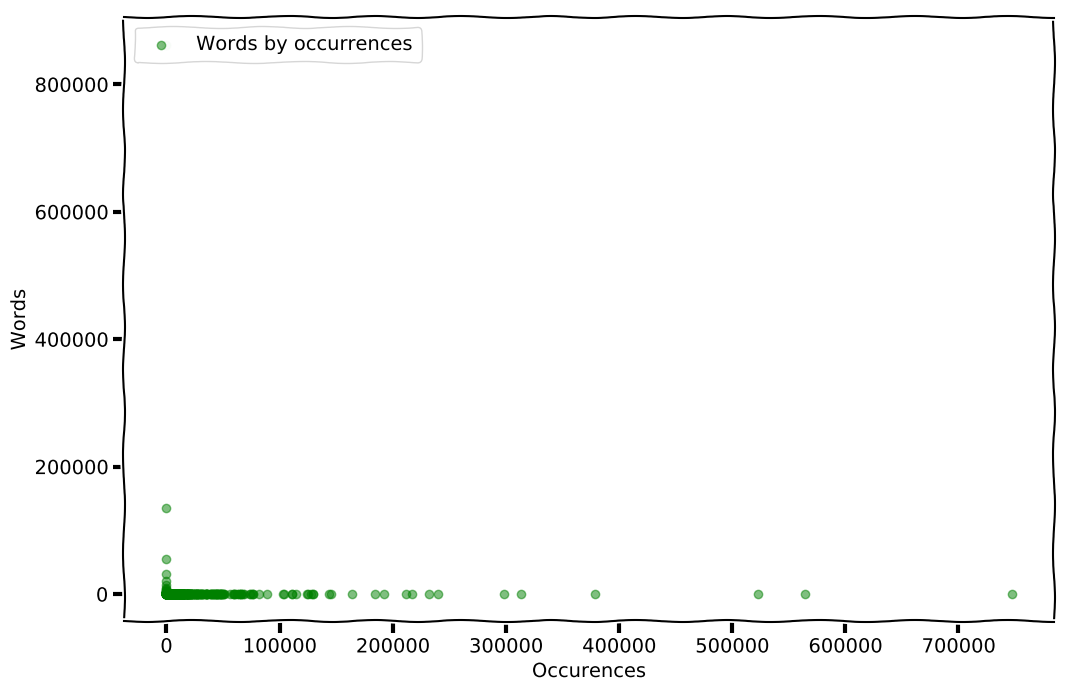

In [6]:
import matplotlib.pyplot as plt


def show_count_histogram(values):
    """
    Displays a histogram of given dict-like structure. Keys are used as labels on x axe, while displayed
    values are taken from the numbers of entries for each dict value.
    :param values: dict like structure
    """
    histogram_values = list(len(elements) for elements in values.values())
    with plt.xkcd():
        plt.scatter(values.keys(), histogram_values, c="g", alpha=0.5, label="Words by occurrences")
        plt.xlabel("Occurences")
        plt.ylabel("Words")
        plt.legend(loc=2)
        plt.show()


show_count_histogram(word_by_occurences)

Let's check the first 100 words which have just a one occurence among all the messages

In [7]:
print(word_by_occurences[1][:100])

['poilsh,', 'cnsbe', 'breakdwon', '1984...but', '@eliaosman', 'leeeeeavin', 'night-sk', 'cheque...', 'yeah!s', "alexia's", 'dry..movies', 'caroline&quot;-', 'again?with', '11am...?', 'eramos', 'ydai', 'sonisphere?', 'automator.', 'tomorrow..damn', "no..there's", "g.lyn's", 'worden?', 'regardï¿½', 'thanks--!---see', 'biatch..', 'know...please', 'unforturnately', 'davit', 'measurement!', '@contrarywitch', 'sherwood...sigh...good', 'pooling-just', 'heart?~jonas', 'ewwo', 'lol...aw', '&quot;haunted&quot;', 'buttercup?', 'day...practice', '@jeffmorgen', 'mikogo', 'damaged..', '@carissabernice', '@mrs_vanity', 'upcycled', 'http://bit.ly/1aaf6g', '@geministarr', 'giver...need', '@halowrites', 'people...means', '@jmiahonline', '@isdscuba', '@brandithomason', 'ooooohhhhhhhhhh', 'tightt', '@electrosquidkid', "table'!", '@tanondemand', 'samoas', 'trouble...lot', 'boy&quot;...', 'beanbags.', '&quot;dubbel', '@pianoboex', 'bbkcrew', '@monipug', '@laceyturner!!', 'josefina', 'lindsayyys', 'bapps', '

It seems we have a lot or URLs, hashtags, mentions of other users (@username) and special characters like: "...", "(", ")", ":". Let's try to remove them and repeat the same process. Linking to some external resources or mentioning others can be just removed, but some special characters should be rather converted to blank characters, as they might separate different words. Additionally, let's remove HTML entities which may occur in such messages.

We should also consider some common people behaviour, like:
- repeating the same letter a couple of times in a row, in order to emphasize their emotions


In [8]:
import re
import html

URL_REGEX = re.compile(r"(?:(http://)|(www\.))(\S+\b/?)"
                       r"([!\"#$%&'()*+,\-./:;<=>?@[\\\]^_`{|}~]*)(\s|$)",
                       re.UNICODE | re.I)
HASHTAG_REGEX = re.compile(r"#([^ ]+)$", re.UNICODE | re.I)
MENTION_REGEX = re.compile(r"@([a-z0-9_]+)", re.UNICODE | re.I)
SPECIAL_CHARACTERS_REGEX = re.compile(r"\.|…|!|,|\?|:|\-|\(|\)|/|\\|\+|\*|~|`|\"|'|\[|\]|=|;", re.UNICODE | re.I)
DUPLICATED_LETTER_REGEX = re.compile(r"([a-zA-Z])\1+", re.UNICODE | re.I)


def preprocess_message(raw_message):
    """
    Preprocesses the message in order to remove possible obstacles like spelling errors and non-informative
    parts of the texts.
    :param raw_message: 
    :return: 
    """
    message = raw_message.lower()
    # encoding HTML entitites
    message = html.unescape(message.strip())
    # removing non-informative parts
    message = URL_REGEX.sub("", message)
    message = HASHTAG_REGEX.sub("\\1", message)
    message = MENTION_REGEX.sub("", message)
    message = SPECIAL_CHARACTERS_REGEX.sub(" ", message)
    # handling recognized common behaviour
    message = DUPLICATED_LETTER_REGEX.sub("\\1", message)
    return message


# Make the preprocessing and repeat whole process once again
preprocessed_messages = list(map(preprocess_message, raw_messages))
preprocessed_word_occurences = count_words(preprocessed_messages)
print("Have {} unique words for preprocessed messages (it was {} before)".format(len(preprocessed_word_occurences), 
                                                                                 len(word_occurences)))

Have 258413 unique words for preprocessed messages (it was 1204485 before)


In [9]:
preprocessed_word_by_occurences = get_words_by_occurences(preprocessed_word_occurences)
print("Have {} unique occurences (was {} before)".format(len(preprocessed_word_by_occurences), 
                                                         len(word_by_occurences)))

Have 2364 unique occurences (was 2348 before)


Once again, let's check some examples of words which have occurred just once:

In [10]:
print(preprocessed_word_by_occurences[1][:100])

As a next step we're going to consider stemming. 

In [11]:
from nltk.stem.porter import PorterStemmer


def stem_message(raw_message):
    """
    Performs a stemming of the messages. The messages is split to words, stemmed and joined back.
    :param raw_message: 
    :return: 
    """
    stemmer = PorterStemmer()
    words = raw_message.split()
    message = " ".join(map(stemmer.stem, words))
    return message


stemmed_messages = list(map(stem_message, preprocessed_messages))
stemmed_word_occurences = count_words(stemmed_messages)
print("Have {} unique words for stemmed messages (it was {} before)".format(len(stemmed_word_occurences),
                                                                            len(preprocessed_word_occurences)))

Have 214907 unique words for stemmed messages (it was 258413 before)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


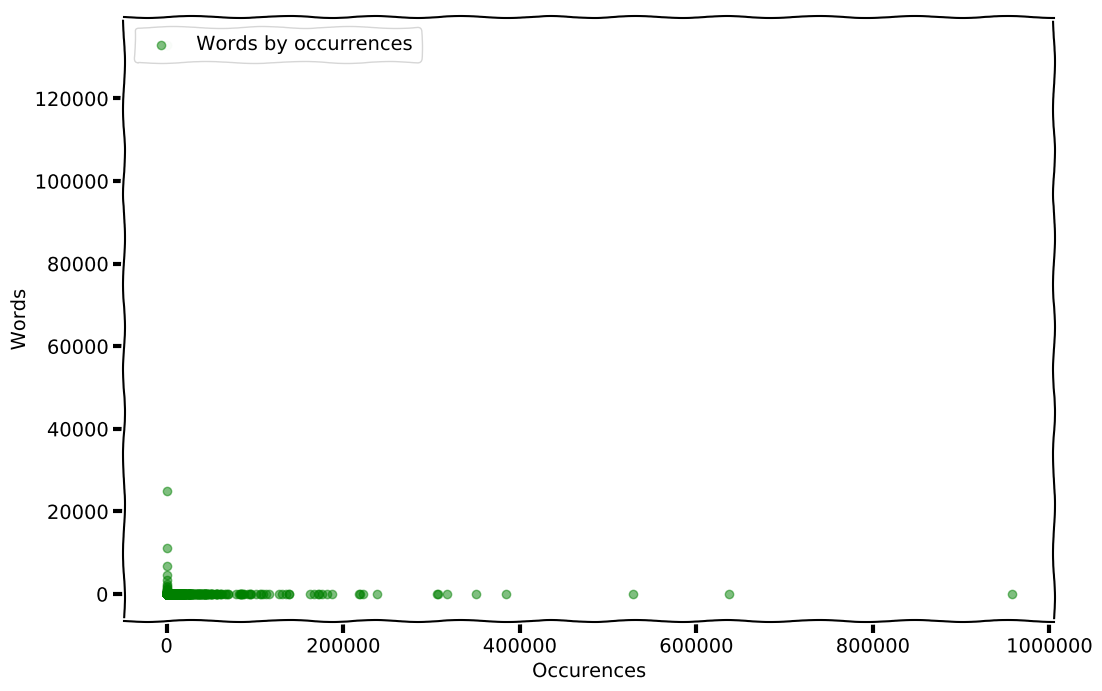

In [12]:
stemmed_word_by_occurences = get_words_by_occurences(stemmed_word_occurences)
show_count_histogram(stemmed_word_by_occurences)

In [18]:
for word in word_by_occurences[1]:
    print(word)

ADOPTERS
http://twitpic.com/7ikxe
Estupidos!
@thistlechick
@kellyisthere
brodcast
non-touch
jOseY
@huckgee
@HeavyRideatVIVA
@sleepyhead026
@Super_Kate
@BrendenHill
eeeeeewwww!!!
@MarkHallett
@CharlotteWildy9
@stushmusic
táº¹t
@SilverGenes
Zhenya,
&quot;ish&quot;
want).
@jessiwithani!
gdmrnn
Davinci,
http://twitpic.com/6aulw
myself...rather
rpattinson
lyrics...ask
though...we're
@Mundo94
http://www.twitpic.com/68ru3
Rid'en
(Golf)
http://www.fckrr.com
doctors!!!
demi-l.org
Midland...I'm
http://tinyurl.com/ov3n9a
@lady_pistons
@chitownmandy
MINGLE!!
luthhhh!
LATER!!!!!!!!!!!!
wedding...really
@fgmp
tehe!!!!:L:L
cutteee
hapus!!
do...worried
expensive*
Jobelle!
Downloadable
brigther
Prad!
@MayleesGarden
@Jdotofresh
Bobbert...move
http://bkite.com/0743U
"mechanical
-Um,
@Cricketa
http://viigo.im/KXz
ME,,
ARRH
dogter
pronto,
Uvulitis
privaledged
bickered
resnice?
skrg??
northeast)
synopsis...not
volatility
notnot
Halograms
MomTV
...brothuz
blessed)
roai!
more...)
5ive?
Perander's
@Karen_Reute

Osi
aqjtdd
@SnapPop
smilepaige:
Mbs
http://twitpic.com/5747w
armory,
emocionante,
@chemix00
twice*
sorry....?
hbuuu?
toady!!!!!
CILLA
@ashlei_necole
CUBS/sox
@EzeeEsquire
Toggle
@BEEron
Hangover-a
http://twitpic.com/68kgk
built_
cruisin'!!
baterry
Graaargh!
torturing.....
Tisdale??
#asperger
http://bit.ly/GndVG
Ironically..
www.myspace.com/brittnisdabomb
iughiugh...i
@yuriarcurs
Captured.
mine...&lt;3
GX
@mryancey
milk...about
http://tinyurl.com/dbv45n
@tweet_sync
http://plurk.com/p/x9kn5
NC.......headed
@abcdefaly
@jeancheah
@mom_moe
@alex_amato
McDo(thats
things...chocolate
hundreds)
http://vimeo.com/3831957
#earthday
#Devunity
natalya!
@MissRobinSher
@Abby_Keshihead
@KayPisces
kidd-
Junkies)?
tired.....but
nationl
shitty...stupid
@smyjamie
razorblade
@Audrey2_Mag,
Printeet.com
@tahleamoonwater
Kiara!
cheated...lol
feelï¿½
ANNAH.
Hoofer
817,
dictor
@catsuncle32
@MrsMicah
@Katalina_Marie
WoooooYeeeeaaaaa!
@dutchbboy
http://plurk.com/p/xdh5y
http://twitpic.com/7gbwb
exhibition!!
@iamem

misery...need
CommunicAsia,
reverie.
spanish...sunday
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
160HP
home...finally
Demi.....
ly&lt;3
....get
@EmoKidsInc
-big
http://www.opera.com
@phoever
fun...im
awake,darn
AdiÃ³s,
givern
tbrah
@Alleefoshow
Stavos
wellsies
speedingtickets
MacKenzie.
@h0neyluv
start-of-week.
culdnt...
@the4v3ry
gerek
keep&quot;.
nQ
Suriname
S!F!D!
7:00am!!!
OhNo!
@marsram
Salamanca
http://tr.im/kpc1
subverting
@hellbillyright
gordo's
1187
get/send
100ml
feet💤
Helsinki?!
@Brittneyannmmhm
again&quot;)
depressd
@traderjon
too-now
PB...sooo
pinch...
occultation?
siing
#nielsenpowermoms
@azrean
Hair...Sad
figureas
gessed
http://www.pegasusnews.com/photos/2009/may/29/30631/
@nanceh89
@IanGraham
waaaaaaaaa!!!!
case'
Affair,'
armys
@AdamKruth
@GMCharicemania
summer...n
MYESH?
http://plurk.com/p/yzj7m
mii.freakshow!!!
there.u've
chien&quot;...
summer?...
2,563
@urbanjax
RadRails
TOOOOOOO.
dockyard
Assumin'
SCOTT-LOTUS-
ufffffff
Dayewalker
http://dallasanne319.blogspot.com
-NN
wrap...

guests;
artwork!!
masturbation.
@Pijrt
burnteded
http://bit.ly/P77q4
@zeejaydee
#HollyMais
yesturday!!!!
respnsibilities!
faovirite/top
'666'.
Carolines
a)Goodmorning...
dibodoh2i&quot;
ahahhahahahah.
@JAJMiami:
laaaaaateee
@ADDN2X
8:28
N(ot
@JamieXVX
step..sucks
(((ej)))
blinkies!!!!
wtf...i
@VANITY_ROCK
http://bit.ly/Hq8se
@gastronauten
fanime,
#DreamJob
@Jcsmithv
Yeah--they're
Dames
http://bit.ly/wsgZP
breakfast...dangit...
soon...Hopefully
house!!Thanks
riiiiiip.
Lufbra
http://bit.ly/V2DBm
(zycam)
fudgesicles.
BikePure
tookme
RnB...*turns
@angryJohnny
Ugh...no
@JimmyTIght
vista!!!
cienna
dual-booted
@tvecero
Courtroom
me...and...
two...but
Telefonmarketing
bumbershoot
http://t.co/pD7R1lL6Re
you,jay&amp;rocco&amp;georgina
place...wish
@ldybond007
babeeeeeeeee
@Veryweirdguy.
http://ff.im/3oVut
@clarespragg1982
TGiF
exists!!!
brokey
reponga
cucumber/mango
http://blip.fm/~4j6he
@analogbettie
tummy...you
@marcbe890
@sommacolada
informace
@HumbleJanitor
Cronin.no
ARAL
#3wordsaftersex.
#N

@ablizno
nelï¿½bï¿½
westlife!!
confirmation...really
@MickeyUnderwood
@pattyWOOO
susquahanna
it-a
@enjoystan
Soul!!!!!!
@rmallik
ALWAYSSSSS
Brucetenci.How
CRAAZZZYYYY
@Marketingtwitt
fake??
multi-pass
scored.....
later,im
estury
@KiLLaHz
@iSamiam
@computeher
4:24AM
Tanner...also
http://twitpic.com/6gom3
terÃ§a
@anpete
man...2
pain.lol
ILY.â™¥â™¥â™¥
babys...only
http://myloc.me/3Zhv
swhere
musicschool
weeeeks,
sucks..................
@hamyams
@Domcuzka
@zcrawford2
sun?.
case...goodnight
http://bit.ly/nfWKC
kat-tun
http://tinyurl.com/djwtvr
@ezpz_sammiz
@PopySauce
Portuguese-Canadian
cooler)
@redapes
www.art4lifeca.com.
alittle...
Jillpot
@jwood1806
@sixfeet
@kingdommama
(Twitterless)
@MizLiberty
http://twitpic.com/6fpie
**cough
album...lol...
myspace.com/kymber_autumn
sun!!'.
early....BUT
recruitment.
@Rannelee
x0x.
coat...but
@juliegoodacre
..In
@arizonagirl06
50,000hrs
@comcast?!
#gmail,
11:16.
http://twitpic.com/6gmfu
#EnglishG
skillled
@itsalliek
@Zamgirl
alighted
bro's..
gmas!!!
GO

Deezer???
@ljbt
http://lookbook.nu/look/129228
@ladyspwrinkles
AIRWAYS!!!
Blehblehbleh...
Bioshock.
TeachMeet
#littleknownfact
hmm.I'm
@jeffraff
bored....that
@mrscracka
WHAT?!?!?!?!
(recommendations
projectpresentation
(sexy
@sophiaalmeida
@DxTruettner
5oz.
@wika2
daddddd.
while...watching
Jibtv.com
Terrorism'
@Okyz
shamelsss
rights~
infliction
@pshidk.
@amirsaid
p2!
@noahwesley
mall....hopefully
@Daniel237
@SteveUccello
http://twitpic.com/68nyf
@breezesblue
@midnightxsun
http://twitpic.com/5c9up
@LAStory
SEXXXXXXXXY!!!
romanticize
SESSIONS.woot.
@duece_toofly
bump..cant
JI'm
http://twitpic.com/6ga8g
tomorrow.....bummer.
@active_ion
@HidingEsther
STALKING.
8PM!!!!
@Spiderduff
gurr!
@dropdeadvictor
@lynnserafinn
normalised.
luuuuuuuuuuuuuv.
#Jottonia
@resistapathy
yelloe!
@lalave
awsome!,,I
expect..
Tongits!
@HOM_JEANTRIX
@mlgore
titans!!
Painyboi
IGNORES
show...hmm
haiyya'
babies.miss
@chinni2487
@tevetorbes
frugalicious
......yucky
989,400
PEI!
you.hihihi
l.a....
http://bit.ly/hyn4V


http://bit.ly/CxF9w
@DebbieRodgers
http://twitpic.com/3yp2t
Heiii
Aw-my
mixer!!!
towes
check......no
Yoursz..
respir!faut
disracted
bachelorette!!!!!
@hilsa
call...will
Twitter/Plurk.
@clefhangerfan
http://bit.ly/dATwK
@CathyBrooks'
hour...with
@ashleyelainee
@pixeledala
hob....
up!Todays
Withnessn
@b4babynames
ago....oops!
gender,i
...tá»™i
@bbkiwi
Darko??
@Delriach
preferir
@surveyspot
@LaidBackRadio
thinking&quot;-New
caido!
jumper..wait
yesterday!!!.
(t??ng
ewika
(waterfront,
procrastinating...just
Waitingi
texts:
Russert's
@mbburns
(coach)
LSAC
worked..it
Beir
stairs...cracked
grounds....but
http://twitpic.com/4x5i1
@itsCaryl
jeff's,
@Bigben91190
Tweetgenius?
broken...i've
Transformer2
bffaeae,
@christinacotter
astronout
Sears...
http://bit.ly/sYnv7
@Natija28
deliver..I
@alfa_maniac
http://bit.ly/qSu4
@ontd_ai
great!?!
@HELENAYAY
aweeesoome
Sanskrit.
@BryanMoore11
@melissagia
@clifto
Billings.app...
GoOoOOoD
Accounting...not
sweatlodge
Rockets!!!
SOUTHERNSIDE
Brewing&quot;.
flakin

@MiRN4RON4lDO
@crushstar
MediaCom
@tweetymike
@astrazombie
Mercer!
&quot;kris
Henri
@cdavid
supporters?
wapiang!
@YvesAndreBFM
ligature
Popers.
buo
um....5
Esterka
@ChristineMarie7
@softball29
SOARS
@nataliemcd
@taniarose
@InKy01
Commercials!!!
picli
@Q_dacreative1
smart............
@freckledmenace
@LIVERPOOLnikki
guestlist!
@jazzii3phiizzl3
int[]
magrelo,
germane
ummmm...it's
day.....bedhead
@PastorBrent
@KiraaaJones
blackjak's
@SammieHines
slideshare,
Thx@SongzYuuup
nobake
pectin?
indignity
lightpole,
gening
describe-
shares,
@CassieLuvzJayk
@ak47nyc
aften!
Morning.D-Day+4:No
Jerry!!
hangoverish
fly?!
broke--
@Heather0831
http://twurl.nl/krej8n
panameraaaaaaaaaa
so,but
hurts.,...
@cybermaniac
@040407
@namwennetsirk
mid-point
poolie!
hihihihihihi!
Cranfills
Kayluh.
enigmatically
laughteeer!
Hachette
@CHERRY_FN_STAR
Monday........
@karly101jonas
toilet,had
@sharaigrant
www.myspace.com/enysmb
aabhar!!
apÄ“st
@witchescupboard
Cyrasaurus
wishes*
economics....woomp
Scotch!
here...Feels
bul

allconsuming
OPEN!!!!!
home...sooo
@MiddleClassJoe
Vimba's
@takuma104
Katelyn.
Ceez
#shared
Croatia..
@Damebeatz
@jasonhalbert
domestic!
BITCHESSSS.
Flame.
Victorinox,
hyperness!!
@daliabuttercup
jerz,
Promotions.co.uk
too!.
ILOC
higlight
B-Day)
spaghetti)
guhroogamesh
@keirajonasmum
helocopter
browine
apologiZ
platains,
&quot;Appreciation
@Crozon
@LaughItUp
http://plurk.com/p/uauio
http://ff.im/-3H6bB
ah...and
@gwenartax
guessed..i'm
rambling?
@arianitd
Huuuuuu
www.itsaboutmusic.com/petehopkins.html
@muhphilram
laughing--just
Northeast??
some-cannot
in...lmao
@dmullen
Lachlen's
Gadsden
@linkinpink
unfurl!
@justinzebell
@sadityNpretty
section.I'm
@Melissa_Johnson
spamy.
bebe..
http://tinyurl.com/monzfc
@LisaRead
&quot;Inteligint
@deannabombchica
imrenbikis
info.Tkt
examz...dreadin
yeah...exciting
*FeleciaRene*
raisin.
yet.Still
#sma09.
catching?
@jennarosee
@jonnyT_Tboy
Everywere
barag
OWIE!!
@jhayjhaze
unhappiness.
Ø³Ù†Ø©
cookings...
myspace.com/missshada90
http://twitpic.com/3jqrw
un

#nomoreaggravation
@aidaa_...i
20.8m
@bettyhallock
God,http://bit.ly/2ooWS
sox&amp;sleep.
156186
http://twitpic.com/4ztai
dry.ow.it
a'te)
@ihatebikes
@DD32
@joannhoho
2day~Help
harbour-side
soooo..im
cream.i
@ms)sugakane
cop..
bloodt
FUN..DON'T
@PerezHitlon
MWF
@jukebox_grad
Gila,
INSTRUCTOR!
screenshot?,
settings..Picture
@easydriver
okeeeee
Ad's
Dancer'
@hales23...why
http://blip.fm/~79lqn
while...The
yam,
@beckiowen
bryyy
gripes,
http://bit.ly/I1yMf
mossie?
can't;
Griffith's
http://ow.ly/7mAL
@TherealDaniCali
Anxiety/Panic
@eliztesch
subs:
Civic!..
then........(What
USD2
theyR
skank)
explosions...
@amywatts
humans~
&quot;Thick
RB)
walkign
moments...&quot;&quot;
digiovanni
sicsicsic
TIREDNESS
Now]
@rpalumbo
gelesen
Lars!
(Connectivity
noon...I
fixed...now
@devinthedude007
girlies...check
chilllllin
&quot;ssdsd&quot;.
Lacan
@mmMariaMmm
#jonaslvatt
earth...can't
Sleep'n
@LegallyBinding
@jballanc
jdges
http://twitpic.com/553mw
DAMNED!
YAYYYY!!!!!
http://www.endeavouronline.net
@jmsnyder

rain...?
dhaba.TIme
ì•„ë¬´ëž˜ë?„
finallyy..i
@ZaneMcFate
@ForSeriousGary
http://tumblr.com/xhd1wrdxr
itssmarian
@Leenilicious
http://www.thewurzels.com/
tonoght
http://bit.ly/6fwMd
#unscheduled
@flyTie
withme
@janabarnello
#wewillsee
@professorgriff
back......in
http://twitpic.com/6qsj6
http://twitsnaps.com/odj@
@starbby
..united's
mmmhmmm.....too
Beleeeedat,
Reiner
puter.Speaking
@Ace_B
Jeallouuusss
@WhiteCandy
http://bit.ly/3d31b
@spei180
URG......Please
@peterdickson
energizing!!!!
(hopeful)
@aozame
@BoBrasher
coast....14
hmmm;
¡è?‰
Hankabear
brilliant.they
bittersweet...like
ridiculous/terrible/amazing
us-we
2030?
alpha2.
Schonefeld.
@GamerDroid
sweet...nothing
game...that
meeeeeeeeeeee???!!!!!!!!!
BDL.
:&gt;.
reverter
organises
@vic_lopez
@gilberke
@studiojunkies
@cnnbrk,
jolie..........im
@Notimeforhaterz
chicken-pork
lie??.
iiF
awale
lolzzzzz
@Woodeh
@TheoDemmer
~Siddy
@derkrawr
@Juuhachi
solitude...
::does
bloodwork...
quise
UTGP
@Headdshots
@alexatv
deadlifting
BASTARD!
515a.


Rim(ming)
tetchy,
@ChicagoToysTV
@yngmoney87
hug;
siiiiiiiick
dingdingding
@kandeezy
yen,
(http://reactiongrid.com/
w/shrimp
bad-hair-days
ROll
waterballoon
pain..got
rainfree
Fox?.
SHELLY
Blugh.
cartoon-damn
Jonasbrothersworldtour.com/JonasHQ.org
http://tumblr.com/xsz21uo3r
doing.?.ppl
/11..
out~!
http://tinyurl.com/lggry9
http://myloc.me/4HIT
certainlyyy..girl
babae,
Krambles
then...haha
@LaurelSturrock
Ð²Ñ‚Ð¾Ñ€Ð¾Ð¹
@miyoung007
@genxblah
internet/twitter.
futuro...it
ë°”ê¾¸ëŠ”êµ°ìš”.
Ã¢.
&lt;--those
@ashley_mac
COVER?
@2LittleMonkeys
@lasagnaranya
@Steenie320
+cowboys
2morw?
Bended
Assman)
@ramblingfelice
ngeplurknya..
#polares
@Lezliew
school.but
@OPCGal
urap
GAPE.
worry.please
gonez
Gorensque!
http://tumblr.com/xgp1z16s5
@WisamAbdulla
soul...my
@phatdippinqueen
@century174
wakakaka..
@funkymonkey1002
@jessstretch
tuum
@stupid_reasons
Comenity
Interpret
'turned'.
tough-guy
BullWinkl
matthews,
yeeeesh
pictahsss
kidding,i'm
Nicckkkkkkkkkkkkkkkk
@valimknights?
@PirateTimmy
box!&quot;
1

summerrry
http://bit.ly/sibzr
Growing!!!
bretttttttttt
@graemeb00th
❤️❤️❤️“@JetBlue:
&quot;...THERE
Lacay
hoildays...
Gentoran
@jtheiser
KCG
@sandymacd
Jurrasik
house..doubt
status,status
lizrose.
http://tinyurl.com/nrfb68
@darlingbuds
TTG
atmosphere!!
@xsumax
again,,,
ë•Œ,
@propagation0
@Rafael415
purdy,
@sparka22
@HeatherMGordon
@BarackObama...Ok
http://twitpic.com/7mz38
mataa
deset
phone...oh
@enscheinfeld
cold...seriously....freezing
hungry...its
form..think
T-21
pang,
hanky..
BRUNETTTE!
@tiggatigga
@musicon1110
reason...im
http://blip.fm/~7eh25
Wake-Up!!
Mazda,
Rapids?
8:30am-5pm
stuff...yea
@FutureMrsKimner
l'initiative
3!);
@jwgrantham
@pawster
him.thinking
good...pappar
Europe&quot;.
u,ha???
survey/ad
Rocko
PIA,
country..?!
B.com(Graduation)
pinkyless
of.lol
@NIKKYPOO
heine/h2o
@JoshGorfain:
Daran!
http://www.xbox.com/en-GB/e309
Individuals
Jealous..got
@mattjohns1
believing'-Journey
07958938647
http://alexisreviews.tumblr.com/post/116340695/ptsa
it.y
Pleasurable
grammar/clarif

crazy-ness..
crosd
@dan13l
@miledha
@alexburov
co.)
MUNKUUUUU.
shallow!!!!!
ex-follower.
balls..!
foooodddd!
@MaliciaGoode
axel.
@emenel,
huny
Awww...Great
@truble_makr
@advisormackenzi
afgan
send'
too...but,
(mijo)
awhr
WIN~
sisters....
@glc107
@KazeYuusha
@dimior
rusher..
f/my
/dreaming
@abby
(burke),
engaged...so
@GroveCanada
@bumble_bella
aloe-d
@ficincarnate
@Cheeeeeeks
crrrrrraaaaazzzzzzyy!
10-man
@MeghanSoper
@CatherineRyan_x
@mcgufbd
sUmmeRr
@120politics
tho...sunburn
home...NOW!!!!!
Medo.
IMMEDIATELY!!
instructables
;|D
Essen,
noise&gt;signal.
Crue.
Troops,
cheers,gonna
http://tinyurl.com/klfyob
pants-free
Anywayyyy...
http://bit.ly/DPJPb
Heiney
@evannuil
Flaxmere
Dudes!
(@KnittingFynatyc,
@balajijegan
(plurklayout)
@Nathan8er
@jepriy's
@mledean
bgnnya,
-Night!
ME...someone
@rayshia91
morningss.
looooog
euroko
OPLAN.
Frane
ÙŠÙ?ÙŠØ¯Ùƒ
Boyle!!!!!!
@nilskassube
Camera!
cntkvrRussian
TOOOOOOOM,
Rhida,
genealogy,
&quot;hilarious-est&quot;
alseeep
fraaaance.
zeros,
moment.I've
&quot

Dropps,
mmmm...interesting
@vinneyt
@christianburke
graduate...hmm..wonder
disfrutis
DRYH
@abbyholland
yuuppp
@tamarajaber
pre-k,
COPELANDDDDDDD,
(july).so
Pick-me-ups
@littletreeart
http://bit.ly/2TdDZ
eofys
@shannonz30
stinksss
@jesus_de_christ
@dreamkillaz
@jeffhibbard
@Dani_girl83
@Sin_of_Eden
@fabsand
wishing!
#TheWrestler
http://bit.ly/pd9h4
cry...I'm
don't,I
bdo!
http://bit.ly/oUZrq
toria!
@zappos_Latrira
@wilsonscents
4:23.
#russians
548
@aleksagosto
?Hablas
siblings!!!
conde,
nushki!
..@davork
subpages
http://usat.me/?35404568
@RuthOUTspoken
STONED
troycity
GERMANY...JANA
Yaaayyy,
farrel
@andybrowngolf
smallTU,
Pinky,
MMVA's,
em',
Ohhhiii
it...laterz
http://yfrog.com/59n7aj
@thunderstorming
@vmason
@kissandtype
(police)
deathfic
@vpaquet
drift!
choreographers/dancers
Mussoooooo
txting..
kserei
Itsuki
@chachatea
juice........but,
Lol.You
gUrU
LOBSTER
Iklan's
@xnywewx
@TyaKaThatFlyGuy
@Whingeing_Pom
@bennylen
@thrills
HOT)
@radtke327
tshirts...
Nikki..
ISLANDS)
facinating,
@coup

Jehovas
@landaux
Regards.
Waaaaah!
scfi
@reggiebot
Sooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
seniorita...
skip-counting
@ashleeyhayden
Aside&quot;
#notacareintheworld
out.....I
@charhjc
http://twitpic.com/4gygt
Dunkin,
ONWARDS
splendidly...
Slik
cieta.
http://tinyurl.com/kijkduin
...watev
@annehaines
http://yfrog.com/42ytdj
FOO,
mcdonald`s!!
iGirlyPimp
Somerset!
@cally1324
nOne
@spicyem
Ð¸Ð½Ð°Ñ‡Ðµ
chiro/physio
unrelated,
OMG.i.miss.camp
@AlexaPhillippi
@rsomers
@alexfarber
@sportyamanda
sammys
http://plurk.com/p/ucy7t
sick-lily
will/should/could
baseball...too
@rogerfederer31
MCMANUS'
Ephie
@Diligent605
&quot;Lawrence
@webbyfrost
@LauraOliver
oooooooooooooooooo
Ð¼Ð½Ð¾Ð³Ð¾Ð³Ð¾
forget&quot;....Easy
LOL...get's
hahaha....great
www.soyezfous.com
class..sigh.
spelt?!?
storm/
spoleto
mind..you
@fkingrrr
http://www.elliottkember.com/spreadtweet.html
@tiinaalee
1.Thanks
addictedd
@Bobisdead85
Jaya
Fankit_Les_sims_2_mes_petits_compagnons.rarFankit_Mysi

myspace-syndrome
Hagd
@effingnothing
stueps
platonic&quot;?
&quot;run?&quot;
-Coral
@Kritzmat
http://plurk.com/p/risdy
sorry...looks
@MoniqueMocha
sledgehammers
@iiyann
pointsâ€¦
twayers
dream!ok
collaborate!!
activision
&quot;executioner&quot;...
NelMaNo@
person?coz
Mina's
LAB!!
jabbys!
sky1
http://twitpic.com/4yq1u
@annebeanva
@hepp
@blaken09
spymasters...unless
@KiMbY626
celup
@nateleaf
http://twitpic.com/7gj31
@sicknastylaura
possble
Ant&amp;Dec
http://twitpic.com/6beob
brover
#Solid
@30SECONDSTOMARS.
INT2
Amilie!
fawked,
@jbradshoemaker
glycoma
@2hdesign
Begitu
@ned_ned
@propagation
@wanderinghotel
dealed
D)charas
horse--Scout,
@icy_sun
@IrCheryl
http://plurk.com/p/z3ta3
medium.....but
http://tinyurl.com/o882yl
http://tinyurl.com/nhkb29
that...being
@chantelm15
yest!!!
weather....Baby
@chiusterz
dear...your
albumu
http://twitpic.com/5f07d
haaaang
goodbye..Im
TRs
@ivysoon
ding&quot;?
(Fuckin
@MarkChavez
ventimiliga
bedmate.
@PhilPacker
forgot&quot;
perhatiannya!!!
oh..bye
@carlos_a

ChloeChloeChloeChloeChloeChloeChloeChloeChloeChloeChloe
@DJsexyTIME11
bea_sievert17@yahoo.com.ph
went????
grrrrrrr....I
oh...wow.
ï¿½MORMON
Pubs!
184,976,433,497.
Mac-wise?
ESSAY?)
score....so
@MechaWeeg
WITH...OH
ï¿½n?eleg
hereim
@nat_xoxo
forever-miley
Chocca
fpom
@BriKi
@yourscenesucks
Grint......&amp;
Lindsey:
shopshopshop
rugi
vui!
http://bit.ly/TfYLy
AdFix
lessons???
dizzzy,
nyla
1000'th
Bati...
&quot;Home&quot;.
@Minxy_OperaCols
[frowns]
@djddouble
@tonguefu69
Rasta.
branhaven
#NAMS)
@avaz
l'inverse
50K.
http://twitpic.com/6ewg9
@Meldina's
manakin
W-N-U-A
OmG.
mimir.
kids...tell
gniight.
@ericwakeling
oooverrrrrr!!!!
@Eugen_S
@traviswill
thannnnnks
thirstily*
Kousagi.
Headign
Morrison!
'Hard
gggggggggggggoood
@acciemaj
'conference'
OVERDOSE
vienna...
@artimentary
koko's
http://yfrog.com/0fnvnnp
HBO..forgot
@RubyVixen
@charleysayspop
FAIRLY...somehow
http://t.co/0EWj7oKlji
Woman..
farley&quot;
great-grandfather
ØªÙ„Ù?ÙˆÙ†ÙŠ
brees
Meanie!!
@jilliandee
Humanities,
infinity&quot;
Sa

@WavyChildPrince
homeMADE
@priscilamizuta
Stink
salvating
http://bit.ly/RP3km
@fifonseca
@KelleyVick
Fraser...
Married&quot;...eating
Richy!
'Hope
thunk?!
necklace..finally!
http://twitpic.com/6fezi
@SexPortal
@ashaberry
Moooooooooorrrrning
Guess...life
CAVALIER
@jamesrbeaumont
@WebArchitects
-hand
loveyousomuchhhbabeee
trackbacks&quot;
Edgar_Baruch:
sober??
heartburn..
Terebithia.
(expected).
@CarrieAnnNKOTB
@instamuse
'phone.
Ah..these
http://www.myspace.com/modsun
subect-thanks
tannage,
â™¥~mrs.graham-bush~â™¥
@jmjayfo
starrrrbuccckkks
&quot;Voices&quot;
truuuuuue!
@kelsifulton
idem.
@thinxtoomuch
acc's
@whiskey40
gawdd.
@coryoguinn
http://bit.ly/10zXnI
@BriaRaesMom
wifi...RD
booby...
Bryant...
honors??
BBQ...i
Egypt's
better..:p
@DJ_ATM
problemo...
@erinregina)!!
@Q103Albany
35....man!
out.....gonna
@Craigsworld
euro-pop
@Lawrence_Leung:
Rogers...unless
..CYBER-CYPHER.COm
(tryin)
@JasonBradbury.
http://plurk.com/p/117pj4
about----hahahah!!
@CTD
Dougiee
may...can
Ð¤?
Mondays...ugh!


game..Hope
@PoshPastry
LoooooL
curang!
bit...tweeet
@rosskieswetter.
ppwk,
stuopidly
dead!,
http://twitpic.com/6rv7j
http://twitpic.com/6r3vl
@BenOCMckenzie
@herbtheentspec
http://myloc.me/401b
@Nicholas_KTS
EUC
Sophp
@renatagag
SiLky
fatfatfatfat
@rjgeyer,
Slime
stereotype!
me=infinite.
@Kristiealley
shiznit...
@popcandy
@robswissarmy
PAH!You
worst!!!!
Thrillbilly.
L10!
expirence
fock!
http://yfrog.com/0ltrdaj
@fleurdevie
@Albz86
@Elquinjena
Environmentalists
dude...hope
tamron!!
AAAAAAAAAAHHHHHHHH!
boring...just
-Rive
@JustineRBI
Well,,,
mickeyd
JERBY
bands-but
@_exceptionally
Calabash
@Abionfire_X
wendys!!!!!
running.....good
Stratch
GODDDD!!!!!!
DEADASS
@theauthorguy
Work,tried,sick,fever,stressful
C!I
A&amp;P!!
pool..it
attackedd
http://plurk.com/p/vh617
anywhere...ugh...well
@Cinecism
this...sigh
Tele2
#zonechild
zeee
ditcher!
deaux!
jessy!
caribeaner
japanese!)
http://blip.fm/~7tj96
http://tinyurl.com/265ogs
heard..i
Evenstar
omellette?
@amulsp
landslide.
(conf
http://tinyurl.co

#brucon
brf
http://www.onlyoz.com.au/
@tinkcashley
@Broncogirl97
Yorks&amp;Humber.
makanan2
@yupitsshaunda
UA1297,
@woaivic330
reservations)
itt??
Strasburg,
@adjonesjr
http://twitpic.com/5opia
@vgzombies
`yermom`s
http://myloc.me/262O
today;;
...~sniff
@Eyllek2,
#twittersoapbox
'regeneration
show/UK
ccg/tcg
(run
http://is.gd/AXYK
@chictopia's
miroir
@teencastic
me+I
schmanielle
f"
Singeer!
dapper?
@damianboys
&quot;sahara
http://twitpic.com/4gsah
Trickery?
Waahh!
@myheartandmind
@ONLY1ME09
@thuybee
shit..that
Jose/
socialwavelength.com
@robynmae
@xxxWhiplashxxx
wo0o0op
@Ion_Cluck:
@AlexKayle
http://www.kathrynvphotography.com/
Marais,
@suvienna
completed..sry
1--It
braces...WHY,
piti
http://bit.ly/no_deposit_required
http://bit.ly/Upjf8
N9UMJ-7
Pyle..I'll
@NickWeikert
at-
too.....LOVE
http://tinyurl.com/m7xzk9
wiThout
@stylegallery
overreaction...
Baws.
Katamari,
Allergies....screwed
@onicoara
@diioxyde
&quot;Gentleman&quot;
welcomeee!
j/k...nah
sunday,ppl!
atmels
cutie's
@anarborgreg

Cran-Grape
#stillsmokefree
umhh.....
greaaaaaaaaaaat!!!
http://twitpic.com/7zt4e
@adriangrey
prob...just
-door
Drysdale
FashnsSwthrt
'Property
july/august...
daddylonglegs
actors/singers
FOTC!
hHahisklfas
DLF,
http://tinyurl.com/mlkjkk
@ImperiusRex88
@Rukkie
mtl?
Ð²ÐµÑ€Ñ?Ð¸ÑŽ
Rings?
allahares
Argos....
YAYYYYYY!!!!!!
bail-out
@berend
tonight............
@rubymarie
http://tr.im/pu6S
CHELSEA.
@MsBrandi_
@Brittany
1-930,
8.0.2
moomba!!
@weaverdoug
@KimberSeguin
CMs
@boysnoize)
@venite
WHATABURGER.
Headers
sun...LOL
@janiefinlay
b'dos
synical
faceprayers
Vikisaurus
out...allin
empowers
@hhf3
crush&quot;
rockier
http://bit.ly/15Jned
http://blip.fm/~5eh2b
@mattysalyer
while..doesnt
@nenasymone
lost'
@ChesterB
Aaaahhhh!!!
@acharmingmouse
http://bit.ly/tPnUm
headache....ouchieee
@DTL,
http://www.twitpic.com/5555g
@MeganRiera
miss....hang
http://www.supernova.com/events/5385/vote
MOtherfuck
shining,again!
lib-ra-ree
Flowers....
regester
Storytellers
@windryderm:
noua
Kafka,
&lt;---WE
SR-408
@oh

http://plurk.com/p/z05ne
privilege!
time',
POWs,
@cisforcristinaa
represents...
squirrels?
53Lf
nowaz,
BLEGHSTICKS.
high,forgot
@so_andy_said's
#uncaring
3/10/2010
miez
cutesyyyyyy!!!
@Sarah_Hope
Exploded
potatoe-island
(Text
sA
hoeeeeey
non-airconditioned
lovelies!!
him4him.
here...at
@KAsbell
macros...but
reuninion
@balletchick49
fUCKiN
Mickelson...what
@Kristen40629
anniversary??
wallingford
@MeryStreetTeam
visitmix.com
@Diamondent,
@azcameron
beanbags.
orthodontists
right-got
squeezes}}
SPAAAAAAAM
killie,
@mskenyattab
STORY&quot;
Python&quot;.
ignored)
Bloomsday,
chee,
Fucc'n
@Curtis91
fez.
Uughh
pi100
Subscribe,
Ugh....snow
(Ooooh
Endy.
@marlenemanto
http://twitpic.com/5dua2
again...whilst
Adsa's
xoxxoo
hers..so
stats-
why?????...............
http://myloc.me/2NCr
http://twitpic.com/4wz7p
concert...NO
yo!!!!!!!
jo*
@mr2020
DYSFUNCTIONAL!!!
http://tinyurl.com/llq6oa
Targets.
http://bit.ly/NxTZC
f-up,
@SonnyShear
IMs,
@jadoredaff
@forfunoficial
whoooooopppppyyyy
phone?I
@tjohansen
aw

@charlieshrem
@hookandhunttv
@SexyCityMag
http://blip.fm/~8aot4
abadi
http://thesillyshepherd.onsugar.com
baked-in
Maymont
breaths....regroup....close
Cadillac?
rain....grrrr
http://blip.fm/~6j0mx
http://t.co/cdZhTyd0aK
@toni_gpb
www.IrwinHeritageDays.org
PROM!!!!!
flag..
http://bit.ly/S4ycG
@TiaLouWho
raku
2-3pm.
MMS....I
@Pedyg
sad/bad
TechCrunch's
BNA?
S!CK!!!
@Theezy21
w/Wii
@theBetaGuy
armss
http://twitpic.com/6otw0
@FatFighterTV
please...her
@a_hippie_chick
Dip.
@ZintaAistars
#tourseries
RAFA.
cheese-tease!
Duskwood,
@Ambie812
iconing
Hey...@MrAdamLambert
@PaulDawsonSr
writing....physics....writing....words
http://twitpic.com/7x3f2
#bethann!
@CompanionofNine:
@flairs
Barkarby
http://bit.ly/btFPx
loveofmylife
http://blip.fm/~7g9fb
pulsing
gagging!!!
http://yfrog.com/15kwaj
super-lazy.
integra
weekend..hoping
ben(:
plans..DAH.
pon!
mgy=
http://twitpic.com/87lpp
@lisadavies_
@krunkjess..thinking
nih!..oh
http://www.etsy.com/view_listing.php?listing_id=22894683
Lawd,
@AbiLovesMcflyx


(cont),
@surrealexchange
tiiiiiired...this
baris
parque
89.0
can...oh
@sooofje93
@Celeste_Cheri,
'TILL
chill..very
#WELCOME
http://twitpic.com/6s6hd
runout
@TRAINS_SPOTTING
http://tinyurl.com/aaj2pa
ScootsMagoo
credit"
Brodie!
Howya
ACDCs
everyone..How
@StephanieKohler
guirars
@tinyanl
@shawnie123
spread?
@Cubicz
@MoondanceK
Extreme)
janelle.
Lunch@Crossroads.
@learnITonline
Raul!
Bossanova
alanis!
&quot;uhhhh
@filmstory.
though?!?
super-carbonated.
work,,huuh..still
@SuperCarine
chiilaxing
@collectiveshow
goash,
http://twitpic.com/6bcvd
@richardsession
wtason
http://www.worklifebalancecentre.org/
loansome
@scibuff
~Nani
rees's
fuckerrrr
@green95j
PBR's.
@sj32!
Tatting
telcel
&quot;KÃ¶ln&quot;
phew....good...normal
Gurnee
http://plurk.com/p/ytdkz
denny's...having
http://bit.ly/9763c
#cnnfails
@GothicPeople
channel?)
Harrison...much
@loungeradio
taters.
mackerel...
Thaaanksz
Clubman
@Kwiet
observations.
Daurissa
aaaaaarrrgghhh
http://tinyurl.com/ddyd8p
him...Love
it....hmmmmm
@GeorgeZaf

Toiletface.
http://twitpic.com/509bc
annoyed!!!!!!!!!
sorry...much
minee,
http://blip.fm/~5z3co
drunk-make-out
again..my
$949
well...except
LOLOOL....i
Mam,,,honestly
@quoteguy4
Krugman,
''saving
wuvvy...u
though....see
Cipriani
@Serescobar
Washington...by
http://tinyurl.com/luz9ee
confessions&quot;
HAHAHAHAHAHAHAHAHAHA
ampalaya
@Rusty_Nelson
stomme
verrryyy
Sidenote:also
@Elisa_Detroit
thing-LOL.
@jimhill
brain!!!)
@JustCallMeTT
Boorrred*
ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½'''
dealing.
OPAC
Butts,
pooool.
finally....well
Arabella....I
á»«a.
soaps..
months-MY
location....
Chile's
@brittany_ko:
coffee...this
scrcipt
@sbfreelon
@Wizet
http://bit.ly/165ZFk
@youngbanks206
Book-how
@MIZZVEGAS
@Aesthesis
on...how's
@annakayh
Unpacking!
husvand
pschh
excellent...thinkin
task..!!
Baloe
Portugese
spousey
@saud264
brie,
ILLEGAL!!!
@richardhuf
tsss.
greatnesss
#TwitterTrain
@swadeshine
http://blip.fm/~6sw0k
@jfink77
Doodle.
stimpacks
#happy4them
lifeee..
cunt;
loves...vicki
@thebonaventure
choice!xx
mohawk,
perfo

kawaaaaaaaaansss
ngefollow
perhap
attitude.....hate
@FakeFielding
CR*P
jombo
obviously~
schuhz
ÐºÑƒÑ€Ð°Ð¶
Ð›ÐµÐ³Ñ€Ð°Ð½Ð°.
Kembla
21...awww...and
http://tr.im/lDwW
Moviethon
Poems,
howss
terminale
spicier,
Handbrake
mimobot
waz.
@ElaMesa
http://myloc.me/3THx
veghead.
@Iam_Lyric80
@c0urtneyward
ppc
pavlov
&amp;sick.
sun...I
http://tr.im/jeCO
@Rashi82
daneille
night...Sowwwyyy
@notcharming
tabithaa
HOLLAAA!!
name-wise
http://twitpic.com/75res
*beep*
niGht
@DianeTyburski
quartz,
....randomly
@AlexiaL
Mondavi.
@CAHinxman.
http://bit.ly/13qWMV
@missjneal..
VTC
29..the
@JuicyFruits88
Kateland,
shetland,
The.Reader...because
Bills,
manndayyyyy!
Outraged!
@huntermello
@Fecruz
Schreiner's.
MEAD
@shannonnnn
tv...grrrrrrrrrrr
PILLLLZZ!
ackland
awawaw
class...OMG!
me..lots
Turkey?!
low-capacity
Beauty-Experten
rappn
@JoshuaMLB
$79.90.
http://bit.ly/ULmik
@squidella
alms
http://twitpic.com/48b8q
@DowntoEarthMama
messssSSSsssy
http://twitpic.com/6bo48
27.02.2002
scra;pbook
Rincewind
manila!!
http://t

@giryan
@h4rdc0r3
account”
Bottles,
sLeep..atLeast
waylon!
tfc?
UGGH
Farmville!
@martinmbugua
http://twitpic.com/4gy5r
ohmyohmyohmy
@laurapea
redownloading!
http://bit.ly/34kTjH
@FantasyRace
@missmac_
do......omg
does..whateve.
EEA
forever!&quot;
3'ers
lite)
first-year
on^^
wicked-fast
'kille'r
owiee!!!
@theRealBarefoot
Leona.Tell
candle.&quot;
http://twitpic.com/6bnlk
http://blip.fm/~7dzpf
$less.
http://blip.fm/~8adbh
olives--I
Ã¤rkekonservativt!
no?.
haha...flash
&quot;Roller
http://bit.ly/TdHLX
http://tinyurl.com/oeczf9
&amp;taylor
@BabsonPortland
@TheFreditor
yeeeppp
@eugenekhoo
@phoenix968
sem=sad...
Hepburn,
mp3.com
recorded...that's
CVBs
dance...wish
http://plurk.com/p/11e8g0
@erika_lukanov
Teresa..
stormin!
@jamesjumpsuit
sumbitches!
@GManFromHeck
now.@thomasfiss,
mothman.
time...make
Salamah's
....Loooooooooving
&amp;eki...
@EmilyFlippy
puffy&amp;deform
jajah,
@ChungLi
livei
@ngma107
day/evening...
@diazsuicide
soon-to-be-former
OMGOOOOOOSH
omg!!!b
@annikarae
Shale!
ocean!**wa